In [1]:
import gseapy as gp
import pandas as pd
import numpy as np
import scipy.stats as stats
import glob
from biomart import BiomartServer
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import gseapy as gp
import os
from collections import defaultdict

from sklearn import decomposition
from sklearn import preprocessing

from scripts import aesthetics

aesthetics.activate_paper_rcParams('illustrator')

from scripts import manuscript_colors as mc

pd.set_option("display.max_columns", 1000)

# RNA Figure Making 

Similar to other contexts, the RNA analysis workbook was getting far too complicated. I'm going to make the RNA figures here.

In [2]:
rna_data = pd.read_csv('data/gmkf_neuroblastoma_tpms.csv', index_col = 0)
dosages = pd.read_csv(f'data/gmkf_neuroblastoma_tpms-dosages-for-sv-rna-analysis.csv').iloc[:, 3:].set_index("ID")

In [3]:
analysis_svs = pd.read_csv('data/svs-for-sv-rna-analysis.csv')

# and our actual results
sv_rna_results = pd.read_csv('data/sv-expression-results/sv-gene-rna-results-all-cohorts-all-analyses.csv')

sv_rna_results = sv_rna_results.query('cohort == "gmkf_neuroblastoma_tpms"')

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (34,35,37,39,41,45,47,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302,303,366,367,381,382,400,401,415,416,430,431,449,450,464,465,479,480,498,499,513,514,528,529,547,548,562,563,577,578,596,597,645,646,647,648,649,650,690,691,692,693,694,695,713,714,728,729,743,744,758,759,773,774,788,789,803,804,818,819,833,834,848,849,863,864,878,879,893,894,908,909,923,924,931,937,943) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
sv_rna_results.head(2)

,name,sv_effect,genic_relationship,gene,sv_coding_counts,sv_noncoding_counts,sv_unimportant_coding_counts,#chrom,start,end,svtype,distance,cohort,cohort_af,average_cn,mean_exp,num_rna_genotyped,num_greater_0_dosage,mean_greater_0_dosage_rank,mean_greater_0_exp,mean_leq_0_exp,mwu_p
23078,PedSV.2.5.2_CNV_chr1_6,noncoding,PREDICTED_NEAREST_TSS,OR4F29,0.0,1.0,0.0,chr1,257666,262901,CNV,187839.0,gmkf_neuroblastoma_tpms,NaN,0.224638,0.266629,89,15,0.492045,0.247333,0.270541,0.912668
23079,PedSV.2.5.2_CNV_chr1_7,noncoding,PREDICTED_NEAREST_TSS,OR4F29,0.0,1.0,0.0,chr1,262333,288667,CNV,162073.0,gmkf_neuroblastoma_tpms,NaN,0.862319,0.266629,89,62,0.489736,0.255484,0.292222,0.620135


# Load categories

In [5]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/CWAS data for Jett/List of variants by category/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t").rename(columns={"emd": "end"})
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding


In [6]:
#########################
### FRAMEWORK RESULTS ###
#########################
framework_results = []
for file in glob.glob("data/CWAS data for Jett/CWAS sum stats/*.txt"):
    if "12_26_23" not in file:
        continue

    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"
    af_category = "singleton" if "SINGLETON" in file else "rare"

    data = pd.read_csv(file, sep="\t")
    data[["disease", "sv_category", "af_category"]] = [
        disease,
        sv_category,
        af_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)

In [7]:
num_tests = {
    "neuroblastoma-coding": 279,
    "neuroblastoma-noncoding": 940,
    "ewing-coding": 267,
    "ewing-noncoding": 916,
}

In [8]:
framework_results["bonferroni_p"] = framework_results.apply(
    lambda row: row["p_value"] * num_tests[row["disease"] + "-" + row["sv_category"]],
    axis=1,
)

framework_results["bonferroni_significant"] = framework_results["bonferroni_p"] < 0.05

In [9]:
framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,disease,sv_category,af_category,bonferroni_p,bonferroni_significant
0,0.175033,0.771178,0.226968,0.820448,2,1,644,646,12,1,4687,4699,20,DEL.SINGLETON.ANY.missense_constrained.ANY.sig...,DEL,SINGLETON,0.003096,0.002554,0.002619,0.085949,neuroblastoma,coding,singleton,228.905063,False
1,0.245302,0.150614,1.628679,0.103381,53,1,593,646,309,2,4403,4699,479,DEL.SINGLETON.ANY.unconstrained.expressed_in_a...,DEL,SINGLETON,0.082043,0.065759,0.067727,0.985559,neuroblastoma,coding,singleton,28.843295,False


In [10]:
framework_results.query('bonferroni_significant == True').groupby(['disease', 'sv_category']).size()

disease        sv_category
ewing          coding          8
neuroblastoma  coding          8
               noncoding      28
dtype: int64

In [11]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/CWAS data for Jett/CWAS frameworks/*.txt"):
    if "osteosarcoma" in file:
        continue

    disease = "neuroblastoma" if "neuroblastoma" in file else "ewing"
    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

# Reproduce original findings

In [12]:
# coding SVs can be important or unimportant
noncoding_ss_sg_svs = sv_rna_results.query('sv_noncoding_counts == 1 & num_greater_0_dosage == 1 & sv_coding_counts == 0 & sv_unimportant_coding_counts == 0')
coding_ss_sg_svs = sv_rna_results[((sv_rna_results['sv_coding_counts'] == 1) | (sv_rna_results['sv_unimportant_coding_counts'] == 1)) &
                                  (sv_rna_results['sv_noncoding_counts'] == 0) &
                                  (sv_rna_results['num_greater_0_dosage'] == 1)]

# in cases where an SV has both an important and unimportant coding effect, keep the important
coding_ss_sg_svs = coding_ss_sg_svs.sort_values(by = 'sv_effect').drop_duplicates(subset = ['name'])

single_gene_sample_svs = pd.concat([coding_ss_sg_svs, noncoding_ss_sg_svs])


print(single_gene_sample_svs[['cohort', 'sv_effect']].value_counts())

cohort                   sv_effect         
gmkf_neuroblastoma_tpms  noncoding             7940
                         coding                 196
                         unimportant_coding      37
dtype: int64


196 coding p = 0.02845786918254678 mean = 0.44837902972600807
7940 noncoding p = 0.9998765039234522 mean = 0.502915461888094
37 unimportant_coding p = 0.5558200082237269 mean = 0.5669891977877831


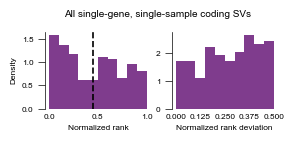

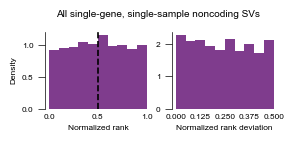

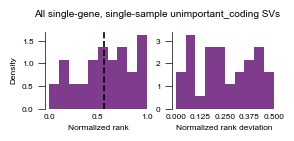

In [13]:
for sv_effect in ['coding', 'noncoding', 'unimportant_coding']:

    ss_sg_svs = single_gene_sample_svs.query(f'sv_effect == "{sv_effect}"')
    rank_deviation = np.abs(0.5 - ss_sg_svs['mean_greater_0_dosage_rank'])

    fig, axes = plt.subplots(1, 2, figsize = (3, 1))
    axes[0].hist(ss_sg_svs['mean_greater_0_dosage_rank'], 
                 bins = np.arange(0, 1.1, 0.1), density = True)
    axes[0].axvline(x = ss_sg_svs['mean_greater_0_dosage_rank'].mean(), linestyle = 'dashed', color = 'black')
    axes[1].hist(rank_deviation, bins = np.arange(0, 0.55, 0.05),
                 density = True)

    for ax in axes:
        sns.despine(ax = ax, bottom = True)
        ax.tick_params(axis = 'x', length = 0)

    axes[0].set_xlim([-0.04, 1.04])
    axes[1].set_xlim([-0.02, 0.52])
    axes[1].set_xticks([0, 0.125, 0.25, 0.375, 0.5])

    axes[0].set_xlabel('Normalized rank')
    axes[1].set_xlabel('Normalized rank deviation')
    axes[0].set_ylabel('Density')

    # calculate a p value
    num_genes = len(ss_sg_svs)
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
    p = 1 - ref_dist.cdf(rank_deviation.mean())
    print(num_genes, sv_effect, 'p =', p, 'mean =', ss_sg_svs['mean_greater_0_dosage_rank'].mean())

    fig.suptitle(f'All single-gene, single-sample {sv_effect} SVs', y = 1.1)

    # fig.savefig(f'images/single-sample-single-gene-{sv_effect}-effect-on-expression.png', bbox_inches = 'tight')

# Calculate for all coding SVs and all noncoding SVs

In [14]:
all_singleton_svs = {}
all_results = []
for sv_effect in ['all_coding', 'noncoding', 'deletions']:
    
    if sv_effect in ['coding', 'noncoding']:
        all_svs = single_gene_sample_svs.query(f'sv_effect == "{sv_effect}"')
    elif sv_effect == "all_coding":
        all_svs = single_gene_sample_svs[single_gene_sample_svs['sv_effect'].isin(['coding', 'unimportant_coding'])]
    elif sv_effect == "deletions":
        all_svs = single_gene_sample_svs.query('genic_relationship == "PREDICTED_LOF"')
    elif sv_effect == "utr":
        all_svs = single_gene_sample_svs.query('genic_relationship == "PREDICTED_UTR"')

    rank_deviation = np.mean(np.abs(0.5 - all_svs['mean_greater_0_dosage_rank']))

    num_genes = len(all_svs)
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
    p_mean = 1 - ref_dist.cdf(rank_deviation)
    p_mean = 2 * p_mean if p_mean < 0.5 else 1
    rank_mean = np.mean(all_svs['mean_greater_0_dosage_rank'])

    print(sv_effect, p_mean, rank_mean, num_genes)
    
    all_singleton_svs[sv_effect] = all_svs['mean_greater_0_dosage_rank'].values
    
    all_results.append([sv_effect, rank_deviation, num_genes, p_mean, rank_mean])
    
all_results = pd.DataFrame(all_results, columns = ['sv_effect', 'rank_deviation', 'num_genes', 'p_mean', 'rank_mean'])
all_results['-log10(p_mean)'] = -np.log10(all_results['p_mean'])

all_coding 0.09096811007128158 0.4672141207916118 233
noncoding 1 0.502915461888094 7940
deletions 0.18228448515782913 0.4298061453556175 155


# Examine categories

In [15]:
nbl_categories = framework_results.query('disease == "neuroblastoma"')

We now need to calculate significance for ALL these categories.

In [16]:
nbl_coding_category_svs = category_svs.query('disease == "neuroblastoma"')

cat_to_svs = defaultdict(list)
for cat, sv in zip(nbl_coding_category_svs['category'], nbl_coding_category_svs['SV']):
    cat_to_svs[cat].append(sv)

In [17]:
p_vals = []
for index, row in nbl_categories.iterrows():
    cat = row['category_name']
    sv_effect = row['sv_category']
    
    svs_in_category = cat_to_svs[cat]
    
    category_rna_results = single_gene_sample_svs[(single_gene_sample_svs['name'].isin(svs_in_category))]
    
    try:
        rank_deviation = np.mean(np.abs(0.5 - category_rna_results['mean_greater_0_dosage_rank']))

        num_genes = len(category_rna_results)
        ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
        p_mean = 1 - ref_dist.cdf(rank_deviation)
        p_mean = 2 * p_mean if p_mean < 0.5 else 1
        rank_mean = np.mean(category_rna_results['mean_greater_0_dosage_rank'])

    except:
        p_mean = np.nan
        rank_mean = np.nan
        num_genes = 0
        
    # if the category is significant, we bootstrap against the background of all SVs
    if row['bonferroni_significant'] and sv_effect == 'coding':
        
        reference = all_singleton_svs['all_coding']
        
        bs = np.random.choice(reference, size = (num_genes, 1000000))
        
        bs_mean_ranks = np.mean(bs, axis = 0)
        
        p_bs = (bs_mean_ranks < rank_mean).mean()
        
    else:
        p_bs = np.nan
        
    p_vals.append([sv_effect, cat, num_genes, p_mean, rank_mean, p_bs])
    
p_vals = pd.DataFrame(p_vals, columns = ['sv_category', 'category_name', 'num_genes_rna', 'p_mean', 'rank_mean', 'p_bs'])

In [ ]:
nbl_categories = nbl_categories.merge(p_vals, on = ['category_name', 'sv_category'])
nbl_categories['-log10(p_mean)'] = -np.log10(nbl_categories['p_mean'])

Let's make this figure

In [19]:
palette = {'noncoding': mc.palette['neuroblastoma']['light2'],
           'coding': mc.palette['neuroblastoma']['main'],
           'all_coding': mc.palette['neuroblastoma']['main'],
           'deletions': mc.palette['neuroblastoma']['main']}

In [20]:
all_results

,sv_effect,rank_deviation,num_genes,p_mean,rank_mean,-log10(p_mean)
0,all_coding,0.265983,233,0.090968,0.467214,1.041111
1,noncoding,0.244063,7940,1.000000,0.502915,-0.000000
2,deletions,0.265463,155,0.182284,0.429806,0.739250


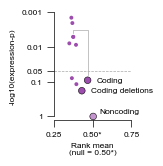

In [21]:
plotted_categories = nbl_categories.query('bonferroni_significant')

fig, ax = plt.subplots(1, figsize = (1, 1.4))
sns.scatterplot(x = 'rank_mean', y = '-log10(p_mean)', data = plotted_categories.query('sv_category == "coding"'), 
                hue = 'sv_category', ec = None, s = 8, palette = palette)
ax.set_xlabel('Rank mean\n(null = 0.50*)')
ax.set_ylabel('-log10(expression-p)')
sns.despine(ax = ax)
ax.set_xlim([0, 1])
# ax.axvline(x = 0.5, linewidth = 0.50, linestyle = 'dashed', color = 'darkgrey', zorder = -2)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'darkgrey', linewidth = 0.5)

ax.set_xlim([0.25, 0.75])
ax.set_xticks([0.25, 0.50, 0.75])
ax.set_xticklabels(['0.25', '0.50*', '0.75'])
ax.legend(bbox_to_anchor = (1, 0.5))
ax.set_ylim([-0.1, 3])
ax.spines['left'].set_bounds([0, 3])

# plot the ALL "categories"
sns.scatterplot(x = 'rank_mean', y = '-log10(p_mean)', data = all_results, 
                hue = 'sv_effect', ec = 'black', linewidths = 10, palette = palette)


ax.set_yticks([0, 1, -np.log10(0.05), 2, 3])
ax.set_yticklabels(['1', '0.1', '0.05', '0.01', '0.001'])

# draw the grey line
top = plotted_categories.query('category_name == "DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding"').iloc[0]
end = all_results.query('sv_effect == "all_coding"').iloc[0]

x_path = [top['rank_mean'], top['rank_mean'], end['rank_mean'], end['rank_mean']]
y_path = [top['-log10(p_mean)'] + 0.10, top['-log10(p_mean)'] + 0.2, top['-log10(p_mean)'] + 0.2, end['-log10(p_mean)'] + 0.15]

ax.plot(x_path, y_path, color = 'darkgrey', linewidth = 0.5)

labels = ['Coding', 'Noncoding', 'Coding deletions']
for index, row in all_results.iterrows():
    x = row['rank_mean']
    y = row['-log10(p_mean)']
    if index == 1:
        y += 0.15
        x -= 0.02
    ax.text(s = labels[index], x = x + 0.06, y = y, ha = 'left', va = 'center')

ax.legend().remove()

fig.savefig('images/cwas-categories-expression-significance.pdf', bbox_inches = 'tight')

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


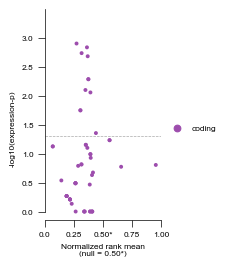

In [22]:
fig, ax = plt.subplots(1, figsize = (1.5, 2.4))
sns.scatterplot(x = 'rank_mean', y = '-log10(p_mean)', data = nbl_categories.query('negative_log10_p_value > 1.3 & sv_category == "coding"'), 
                hue = 'sv_category', ec = None, s = 8, palette = palette)
ax.set_xlabel('Normalized rank mean\n(null = 0.50*)')
ax.set_ylabel('-log10(expression-p)')
sns.despine(ax = ax)
ax.set_xlim([0, 1])
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'darkgrey', linewidth = 0.5)

ax.set_xticklabels(['0.0', '0.25', '0.50*', '0.75', '1.00'])
ax.legend(bbox_to_anchor = (1, 0.5))
ax.set_xlim([0, 1])

ax.spines['left'].set_bounds([0, 3.5])

fig.savefig('images/cwas-categories-expression-all-coding-significance.png', bbox_inches = 'tight')

# Try noncoding

In [23]:
noncoding = nbl_categories.query('sv_category == "noncoding" & disease == "neuroblastoma" & p_mean < 0.10')

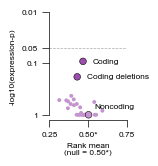

In [24]:
plotted_categories = nbl_categories.query('bonferroni_significant')

fig, ax = plt.subplots(1, figsize = (1, 1.4))
sns.scatterplot(x = 'rank_mean', y = '-log10(p_mean)', data = plotted_categories.query('sv_category == "noncoding"'), 
                hue = 'sv_category', ec = None, s = 8, palette = palette)
ax.set_xlabel('Rank mean\n(null = 0.50*)')
ax.set_ylabel('-log10(expression-p)')
sns.despine(ax = ax)
ax.set_xlim([0, 1])
# ax.axvline(x = 0.5, linewidth = 0.50, linestyle = 'dashed', color = 'darkgrey', zorder = -2)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'darkgrey', linewidth = 0.5)

ax.set_xlim([0.25, 0.75])
ax.set_xticks([0.25, 0.50, 0.75])
ax.set_xticklabels(['0.25', '0.50*', '0.75'])
ax.legend(bbox_to_anchor = (1, 0.5))
ax.set_ylim([-0.1, 2])
ax.spines['left'].set_bounds([0, 2])

# plot the ALL "categories"
sns.scatterplot(x = 'rank_mean', y = '-log10(p_mean)', data = all_results, 
                hue = 'sv_effect', ec = 'black', linewidths = 10, palette = palette)


ax.set_yticks([0, 1, -np.log10(0.05), 2])
ax.set_yticklabels(['1', '0.1', '0.05', '0.01'])

labels = ['Coding', 'Noncoding', 'Coding deletions']
for index, row in all_results.iterrows():
    x = row['rank_mean']
    y = row['-log10(p_mean)']
    if index == 1:
        y += 0.15
        x -= 0.02
    ax.text(s = labels[index], x = x + 0.06, y = y, ha = 'left', va = 'center')

ax.legend().remove()

# fig.savefig('images/cwas-categories-expression-significance.pdf', bbox_inches = 'tight')

# Make a heatmap

Alright, our last part of figure 4. We'll visualize one of the categories as a heatmap.

In [28]:
heatmap_cat = 'DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding'
cat_svs = cat_to_svs[heatmap_cat]

In [29]:
heatmap_rna_results = single_gene_sample_svs[single_gene_sample_svs['name'].isin(cat_svs)].sort_values(by = 'mean_greater_0_dosage_rank').reset_index()

genes = heatmap_rna_results['gene'].tolist()
samples = list(dosages.columns)

In [30]:
# unfortunately, we actually need to reorder these results. We do this such that the RANK is controlled and monotonically increasing
sample_ordering_results = []
for i, row in heatmap_rna_results.iterrows():
    sv = row['name']
    gene = row['gene']
    sv_dosages = dosages.loc[sv]
    samples_with_sv = list(sv_dosages[sv_dosages > 0].index)

    # only singleton SVs here
    assert len(samples_with_sv) == 1
    
    samp_with_sv = samples_with_sv[0]
    
    expression = rna_data.loc[gene, samples].sort_values()
    s_idx = expression.index.tolist().index(samp_with_sv)
    
    sample_ordering_results.append([samp_with_sv, gene, s_idx])

sample_ordering_results = pd.DataFrame(sample_ordering_results, columns = ['sample', 'gene', 'rank']).sort_values(by = 'rank').reset_index(drop = True)
gene_order = sample_ordering_results['gene'].tolist()

Let's do it.

In [31]:
import matplotlib as mpl

In [32]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('neuroblastoma', ['white', mc.palette['neuroblastoma']["dark1"]], N = 256)

In [33]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['white', mc.palette['neuroblastoma']['light2'], mc.palette['neuroblastoma']['dark1']], N = 256)

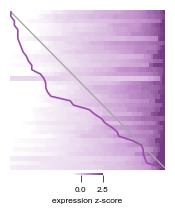

In [34]:
heatmap_exp = rna_data.loc[gene_order, samples]
heatmap_cols = heatmap_exp.columns

heatmap_exp_values = heatmap_exp.values

# we now need to scramble the rows by sorting by expression
ordered_indices = np.argsort(heatmap_exp_values, axis = 1)
heatmap_exp_values = np.sort(heatmap_exp_values, axis = 1)

# create a mask for 0 expression
mask = (heatmap_exp_values == 0)
masked_data = np.where(mask, heatmap_exp_values, np.nan)

# convert heatmap data to zscore
heatmap_exp_values = stats.zscore(heatmap_exp_values, axis = 1)

fig = plt.figure(figsize=(2, 2.5))# 2.8))
gs = fig.add_gridspec(1)

# plot the heatmap
heatmap_ax = fig.add_subplot(gs[0])

norm = mpl.colors.Normalize(vmin=-1, vmax=2.5)
sns.heatmap(heatmap_exp_values, cmap=cmap, norm = norm, 
            ax = heatmap_ax, cbar_kws={"orientation": "horizontal", "pad":0.02, 'shrink': 0.2})

# label the colorbar
cbar = heatmap_ax.collections[0].colorbar
cbar.set_label('expression z-score')

# sns.heatmap(masked_data, cmap=['darkgrey'], annot=False, cbar=False, mask=~mask, 
#                 ax = heatmap_ax, label = '0 expression')

example_genes = [0, 3, 5, 7, 9, 13, 15, 20, 24, 26, 31, 35]
heatmap_ax.set_yticks(np.array(example_genes) + 0.6)
heatmap_ax.set_yticklabels(np.array(gene_order)[example_genes], rotation = 0, ha = 'right', va = 'center',
                           fontstyle = 'italic', fontsize = 6);

# actually going to ignore the y axis for now
aesthetics.strip_axis(ax = heatmap_ax)
heatmap_ax.tick_params(axis = 'y', length = 0)

# label the samples with SVs
sv_plot = []
for i, row in sample_ordering_results.iterrows():
    rank = row['rank']
    # heatmap_ax.scatter(x = rank + 0.5, y = i + 0.5, color = 'black', s = 1, label = label_s)
    sv_plot.append([rank + 0.5, i + 0.5])
    
    
sv_plot = np.array(sv_plot)
heatmap_ax.plot(sv_plot[:, 0], sv_plot[:, 1], color = mc.palette['neuroblastoma']["main"], zorder = 2)

heatmap_ax.plot([0.5, 88.5], [0.5, 35.5], 
                color = 'darkgrey', linewidth = 1, zorder = 1)

fig.savefig('images/expression-heatmap.pdf', bbox_inches = 'tight')

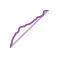

In [427]:
# make a little legend
fig, ax = plt.subplots(1, figsize = (0.5, 0.5))
ax.set_ylim([0, 36])
ax.set_xlim([0, 89])
aesthetics.strip_axis(ax)

ax.plot(sv_plot[:, 0], sv_plot[:, 1], color = mc.palette['neuroblastoma']["main"], zorder = 2)

ax.plot([0.5, 88.5], [0.5, 35.5], 
         color = 'darkgrey', linewidth = 1, zorder = 1)
fig.savefig('images/expression-heatmap-legend.pdf', bbox_inches = 'tight')

# Supplements

In [69]:
heatmap_rna_results = single_gene_sample_svs.query('sv_effect == "coding"').sort_values(by = 'mean_greater_0_dosage_rank').reset_index()

genes = heatmap_rna_results['gene'].tolist()
samples = list(dosages.columns)

In [70]:
# unfortunately, we actually need to reorder these results. We do this such that the RANK is controlled and monotonically increasing
sample_ordering_results = []
for i, row in heatmap_rna_results.iterrows():
    sv = row['name']
    gene = row['gene']
    sv_dosages = dosages.loc[sv]
    samples_with_sv = list(sv_dosages[sv_dosages > 0].index)

    # only singleton SVs here
    assert len(samples_with_sv) == 1
    
    samp_with_sv = samples_with_sv[0]
    
    expression = rna_data.loc[gene, samples].sort_values()
    s_idx = expression.index.tolist().index(samp_with_sv)
    
    sample_ordering_results.append([samp_with_sv, gene, s_idx])

sample_ordering_results = pd.DataFrame(sample_ordering_results, columns = ['sample', 'gene', 'rank']).sort_values(by = 'rank').reset_index(drop = True)
gene_order = sample_ordering_results['gene'].tolist()

Let's do it.

In [71]:
import matplotlib as mpl

In [72]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['white', mc.palette['neuroblastoma']['light2'], mc.palette['neuroblastoma']['dark1']], N = 256)

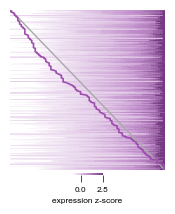

In [73]:
heatmap_exp = rna_data.loc[gene_order, samples]
heatmap_cols = heatmap_exp.columns

heatmap_exp_values = heatmap_exp.values

# we now need to scramble the rows by sorting by expression
ordered_indices = np.argsort(heatmap_exp_values, axis = 1)
heatmap_exp_values = np.sort(heatmap_exp_values, axis = 1)

# create a mask for 0 expression
mask = (heatmap_exp_values == 0)
masked_data = np.where(mask, heatmap_exp_values, np.nan)

# convert heatmap data to zscore
heatmap_exp_values = stats.zscore(heatmap_exp_values, axis = 1)

fig = plt.figure(figsize=(2, 2.5))# 2.8))
gs = fig.add_gridspec(1)

# plot the heatmap
heatmap_ax = fig.add_subplot(gs[0])

norm = mpl.colors.Normalize(vmin=-1, vmax=2.5)
sns.heatmap(heatmap_exp_values, cmap=cmap, norm = norm, 
            ax = heatmap_ax, cbar_kws={"orientation": "horizontal", "pad":0.02, 'shrink': 0.2})

# label the colorbar
cbar = heatmap_ax.collections[0].colorbar
cbar.set_label('expression z-score')

example_genes = [0, 3, 5, 7, 9, 13, 15, 20, 24, 26, 31, 35]
heatmap_ax.set_yticks(np.array(example_genes) + 0.6)
heatmap_ax.set_yticklabels(np.array(gene_order)[example_genes], rotation = 0, ha = 'right', va = 'center',
                           fontstyle = 'italic', fontsize = 6);

# actually going to ignore the y axis for now
aesthetics.strip_axis(ax = heatmap_ax)
heatmap_ax.tick_params(axis = 'y', length = 0)

# label the samples with SVs
sv_plot = []
for i, row in sample_ordering_results.iterrows():
    rank = row['rank']
    # heatmap_ax.scatter(x = rank + 0.5, y = i + 0.5, color = 'black', s = 1, label = label_s)
    sv_plot.append([rank + 0.5, i + 0.5])
    
    
sv_plot = np.array(sv_plot)
heatmap_ax.plot(sv_plot[:, 0], sv_plot[:, 1], color = mc.palette['neuroblastoma']["main"], zorder = 2)

heatmap_ax.plot([0.5, 88.5], [0.5, len(heatmap_rna_results) - 0.5], 
                color = 'darkgrey', linewidth = 1, zorder = 1)

fig.savefig('images/all-coding-SVs-expression-heatmap.pdf', bbox_inches = 'tight')

In [75]:
# for cohort in rna_dict.keys():
#     for sv_effect in ['coding', 'noncoding']:

#         fig, axes = plt.subplots(2, 2, figsize = (8, 4), gridspec_kw = {'hspace': 0.8, 'wspace': 0.2})
        
#         fig.suptitle(f'{cohort} {sv_effect}', y = 1.1)

#         gr_cols = genic_rel_cols[sv_effect]
#         ss_sg_svs = single_gene_sample_svs.query(f'sv_effect == "{sv_effect}"')
#         ss_sg_svs = ss_sg_svs[ss_sg_svs['cohort'] == cohort]

#         for i, svtype in enumerate(gr_cols):

#             ax = axes.flat[i]
#             sv_subset = ss_sg_svs[ss_sg_svs['genic_relationship'] == svtype]
#             num_genes = len(sv_subset)

#             ax.hist(sv_subset['mean_greater_0_dosage_rank'],
#                     bins = np.arange(0, 1.1, 0.1), 
#                     label = svtype)

#             sns.despine(ax = ax, bottom = True)
#             ax.tick_params(axis = 'x', length = 0)
#             ax.set_title(svtype + f' (n = {num_genes})', fontsize = 10, y = 1.1)

#             num_genes = len(sv_subset)
#             rank_deviation = np.abs(0.5 - sv_subset['mean_greater_0_dosage_rank'])
#             ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
#             p = 1 - ref_dist.cdf(rank_deviation.mean())
#             ax.text(s = " p = {:.2g}".format(p), x = 0.5, y = 1.1, fontsize = 10,
#                     ha = 'center', va = 'top', transform = ax.transAxes)
#             ax.set_xlabel('Normalized rank')

#             mean = np.mean(sv_subset['mean_greater_0_dosage_rank'])
#             ax.axvline(x = mean, color = 'black', linestyle = 'dashed')

In [76]:
heatmap_rna_results['genic_relationship'].value_counts()

PREDICTED_LOF                    155
PREDICTED_COPY_GAIN               18
PREDICTED_INTRAGENIC_EXON_DUP     14
PREDICTED_PARTIAL_EXON_DUP         9
Name: genic_relationship, dtype: int64

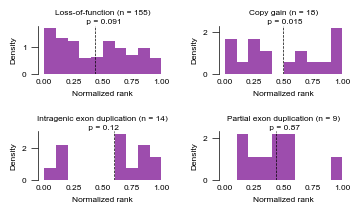

In [102]:
fig, axes = plt.subplots(2, 2, figsize = (4, 2), gridspec_kw = {'hspace': 1.2, 'wspace': 0.4})

labels = ['Loss-of-function', 'Copy gain', 'Intragenic exon duplication', 'Partial exon duplication']
for i, sv_effect in enumerate(['PREDICTED_LOF', 'PREDICTED_COPY_GAIN', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_PARTIAL_EXON_DUP']):
    
    ax = axes.flat[i]
    
    sv_subset = heatmap_rna_results.query(f'genic_relationship == "{sv_effect}"')
    num_genes = len(sv_subset)
    
    ax.hist(sv_subset['mean_greater_0_dosage_rank'],
            bins = np.arange(0, 1.1, 0.1), color = mc.palette['neuroblastoma']['main'], density = True)
    
    sns.despine(ax = ax, bottom = True)
    ax.tick_params(axis = 'x', length = 0)
    ax.set_title(labels[i] + f' (n = {num_genes})', fontsize = 6, y = 1.05)
    
    rank_deviation = np.abs(0.5 - sv_subset['mean_greater_0_dosage_rank'])
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
    p = 1 - ref_dist.cdf(rank_deviation.mean())
    ax.text(s = " p = {:.2g}".format(p), x = 0.5, y = 1.15, fontsize = 6,
            ha = 'center', va = 'top', transform = ax.transAxes)
    ax.set_xlabel('Normalized rank')

    mean = np.mean(sv_subset['mean_greater_0_dosage_rank'])
    ax.axvline(x = mean, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    ax.set_ylabel('Density')
    
fig.savefig('images/effect-on-expression-by-sv-effect.pdf', bbox_inches = 'tight')